# Perfil de Densidade a partir da simulação de um poço</br>

### Script desenvolvido por Victor Carreira
### Colaboração de Rodrigos Mota e Bijani

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import pylab as py
import skimage as sk
import imageio as io
from scipy.misc import imread, imsave, imresize
import plotly as ply
import plotly.graph_objs as go

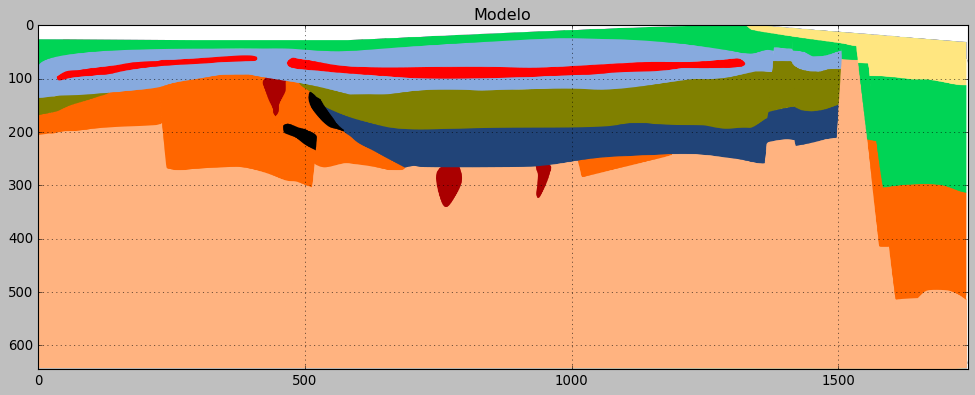

In [2]:
#Leitura da imagem (.png) com o modelo geológico
ma = io.imread("../figs/amazonas.png", as_gray=False)
plt.style.use(['classic'])
py.rcParams['figure.figsize'] = (15.0, 20.0) #new figure dimension
plt.title("Modelo")
plt.imshow(ma)
plt.grid()
plt.show()

In [3]:
#Criando os vetores de coordenadas (xi), com 7000m e o vetor de profundidade (zi), com 2000m.
hy = np.shape(ma)[0]
hx = np.shape(ma)[1]
hz = np.shape(ma)[2]

xi = np.linspace(0.0, 7000.0, hx, endpoint=True)
zi = np.linspace(0.0, 2000.0, hy, endpoint=True)

In [13]:
# para fazer plots dentro do proprio script sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

# funcao go.Contour faz um countour plot usando como eixo x, o xi criado para coordenadas, como o eixo y, o zi
# criado para profunidades, e como o eixo z o plot de valores RGBA da matriz ma.
# além disso, na função go.countour está listando as configurações pernsonalizadas para o colorbar

imagem = [go.Contour(z=ma[:,:,0],
                         x=xi,
                         y=zi,
                    colorbar=dict(
                        title='RGBA',
                        titleside='right',
                        titlefont=dict(
                            size=14,
                            family='Arial, sans-serif'
                        ),
                        thickness=25,
                        thicknessmode='pixels',
                        len=0.9,
                        lenmode='fraction',
                        outlinewidth=0
                    )
                   )
          ]

# a função go.Layout personaliza o layout do gráfico, no caso, colocando título nos eixos.
# "autorange=reversed", da o comando para inverter o eixo y, no caso as profundidades, começando com 0 e os
# aumentando p/ baixo.
layout = go.Layout(
            xaxis= dict(title='Distância',
                        side ='top',
                        color = 'white'
                   ),
            yaxis= dict(title='Profundidade',
                        autorange='reversed',
                        color = 'white'
                   ),
            # define o tamanho do gráfico, altura e largura, e o tamanhado da margem (l=left, r=right, b=bottom, t=top)
            autosize=False,
            width=1000,
            height=500,
            margin=go.layout.Margin(
                l=50,
                r=30,
                b=20,
                t=60
            ),
            paper_bgcolor='#7f7f7f', #cor do background da margem
            plot_bgcolor='#c7c7c7' #cor do backgroud do gráfico
    )


# a função go.FigureWidget cria o a figura com os parametros utilizados na go.Countour e o layout na go.Layout
fig = go.FigureWidget(data=imagem, layout=layout)

#Selecionando as configurações dos dados de fig
teste = fig.data[0]
x_data = []
y_data = []

# criando a função de callback
# para selecionar o ponto inicial e final da perfuração simulada do poço sintético 
def select_point(trace, points, selector):
    x = list(teste.x)
    y = list(teste.y)
    for i in points.point_inds:
        y_data.append(i[0])
        x_data.append(i[1])
        print(points.point_inds)
        
# Sempre que clicar no gráfico chamará a função de callback
teste.on_click(select_point)

# plot a figura na tela:
fig


####### É NECESSÁRIO ESCOLHER DOIS PONTOS CLICANDO NO GRÁFICO GERADO PARA RODAR O RESTANTE DO SCRIPT #######

FigureWidget({
    'data': [{'colorbar': {'len': 0.9,
                           'lenmode': 'fraction',
      …

In [5]:
#apenas rodar quando escolher dois pontos clicando no gráfico acima
mb = ma[y_data[0]-1:y_data[1], x_data[0]-1:x_data[1]]
#mb2 = ma[y_inicial:y_final, x_final]

In [6]:
############# CRIACAO DO PERFIL DE DENSIDADE #############

# ---- densidades das rochas -------: 
# 0 = folhelho | 2.4  |
# 1 = A2       | 2.1  |
# 2 = A1       | 2.05 |
# 3 = marga    | 2.2  |
# 4 = Basalto  | 2.8  |

RHOmb = [0.0] * len(mb)
prof = [] #cria uma lista vazia

for i in range(len(mb)): #Cria um Looping com índice i que varia de 0 até mb-1. Ou seja, 999 elementos.
    if mb[i].all() == 0: #declara que quando o índice i for igual a 0 na posição mn ...
        RHOmb[i] = 2.4   #o elemento do vetor assumirá o valor de 2.4...e assim sucessivamente ... 
    if mb[i].all() == 1:
        RHOmb[i] = 2.1
    if mb[i].all() == 2:
        RHOmb[i] = 2.05
    if mb[i].all() == 3:
        RHOmb[i] = 2.2
    if mb[i].all() == 4:
        RHOmb[i] = 2.6

for j in range(y_data[0], y_data[1]):
    prof.append(zi[j])

In [7]:
## Adiconando ruído randômico gaussiano normal
pure = np.linspace(-0.1, 0.1, len(RHOmb)) # Cria um vetor para receber a imagem da função densidade de probabilidade
noise = np.random.normal(0, 0.06, pure.shape) #Vetor ruído
signal_RHOmb = RHOmb + noise # sinal original com ruído

In [8]:
# para fazer plots dentro do proprio script sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

# funcao go.Scatter faz um scatter plot usando como eixo x, o singnal_RHObm criado com os dados de rhob e
# adicionado ruído, como o eixo y, a prof criada para profunidades

rhob_graph = [go.Scatter(x=signal_RHOmb, y=prof)]

# Define o layout do plot, como título dos eixos, posição dos eixos, cor da letra, etc
layout = go.Layout(
    xaxis= dict(title='Propriedade Fisica',
                side ='top',
                color = 'white'
               ),
    yaxis= dict(title='Profundidade',
                autorange='reversed',
                color = 'white'
               ),
    # define o tamanho do gráfico, altura e largura, e o tamanhado da margem (l=left, r=right, b=bottom, t=top)
    autosize=False,
    width=400,
    height=800,
    margin=go.layout.Margin(
        l=50,
        r=30,
        b=20,
        t=60
        ),
    paper_bgcolor='#7f7f7f', #cor do background da margem
    plot_bgcolor='#c7c7c7' #cor do backgroud do gráfico
    )

fig = go.FigureWidget(data=rhob_graph, layout=layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': 'eaa04466-edfe-4530-9ef7-3895aa5d0561',
 …

# Para saber mais sobre a go.Countour:

### https://plot.ly/python/contour-plots/
### https://plot.ly/python/click-events/#update-points-using-a-click-callback